### LASSO parameter range experiments, summary across all genes

In [1]:
import os
import itertools as it

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import seaborn as sns

import pancancer_evaluation.config as cfg
import pancancer_evaluation.utilities.data_utilities as du
import pancancer_evaluation.utilities.analysis_utilities as au

%load_ext autoreload
%autoreload 2

In [2]:
ll_results_dir = os.path.join(
    cfg.repo_root, '01_stratified_classification', 'results', 'optimizer_compare_ll', 'gene'
)

sgd_results_dir = os.path.join(
    cfg.repo_root, '01_stratified_classification', 'results', 'optimizer_compare_sgd', 'gene'
)

plot_gene = 'EGFR'
metric = 'aupr'

### Get coefficient information for each lasso penalty

### Get performance information for each lasso penalty

In [3]:
ll_perf_df = au.load_prediction_results_lasso_range(ll_results_dir,
                                                    'stratified')
ll_perf_df = (ll_perf_df
    .drop(columns=['holdout_cancer_type', 'experiment'])
    .copy()
)
ll_perf_df.lasso_param = ll_perf_df.lasso_param.astype(float)

print(ll_perf_df.shape)
print(ll_perf_df.gene.unique())
ll_perf_df.head()

(22176, 8)
['MAP3K1' 'TP53' 'KDM5C' 'RB1' 'CIC' 'BRAF' 'JAK1' 'ARID2' 'CSF1R' 'JAK3'
 'NPM1' 'H3F3A' 'GNA11' 'PBRM1' 'MAP2K1' 'MET' 'CDKN2A' 'NCOR1' 'FLT3'
 'CREBBP' 'ALK' 'SMARCA4' 'FOXL2' 'NF2' 'BCOR' 'NRAS' 'ERBB2' 'ARID1A'
 'PDGFRA' 'AXIN1' 'MED12' 'SETBP1' 'KDM6A' 'STK11' 'NOTCH1' 'TSC1' 'STAG2'
 'SMAD4' 'ARID1B' 'FGFR2' 'FBXW7' 'EGFR' 'APC' 'IDH2' 'VHL' 'IDH1' 'EP300'
 'GATA3' 'ATRX' 'HRAS' 'GNAS' 'SMAD2' 'CTNNB1' 'PTEN' 'DNMT1' 'ABL1'
 'PIK3CA' 'NOTCH2' 'FGFR3' 'GATA2' 'CARD11' 'KIT' 'ATM' 'ASXL1' 'CDH1'
 'BAP1' 'FUBP1' 'SF3B1' 'RNF43' 'NF1' 'PRDM1' 'NFE2L2' 'BRCA2' 'PIK3R1'
 'SETD2' 'CASP8' 'SPOP' 'SOX9' 'GNAQ' 'PPP2R1A' 'KRAS' 'JAK2' 'EZH2'
 'HIST1H3B']


,auroc,aupr,gene,signal,seed,data_type,fold,lasso_param
0,0.73614,0.38387,MAP3K1,signal,1,train,0,0.01
1,0.60446,0.26584,MAP3K1,signal,1,test,0,0.01
2,0.63282,0.32077,MAP3K1,signal,1,cv,0,0.01
3,0.66756,0.32635,MAP3K1,signal,1,train,1,0.01
4,0.70488,0.28401,MAP3K1,signal,1,test,1,0.01


In [4]:
sgd_perf_df = au.load_prediction_results_lasso_range(sgd_results_dir,
                                                    'stratified')
sgd_perf_df = (sgd_perf_df
    .drop(columns=['holdout_cancer_type', 'experiment'])
    .copy()
)
sgd_perf_df.lasso_param = sgd_perf_df.lasso_param.astype(float)

print(sgd_perf_df.shape)
print(sgd_perf_df.gene.unique())
sgd_perf_df.head()

(26208, 8)
['MAP3K1' 'TP53' 'KDM5C' 'RB1' 'CIC' 'BRAF' 'JAK1' 'ARID2' 'CSF1R' 'JAK3'
 'NPM1' 'H3F3A' 'GNA11' 'PBRM1' 'MAP2K1' 'MET' 'CDKN2A' 'NCOR1' 'FLT3'
 'CREBBP' 'ALK' 'SMARCA4' 'FOXL2' 'NF2' 'BCOR' 'NRAS' 'ERBB2' 'ARID1A'
 'PDGFRA' 'AXIN1' 'MED12' 'SETBP1' 'KDM6A' 'STK11' 'NOTCH1' 'TSC1' 'STAG2'
 'SMAD4' 'ARID1B' 'FGFR2' 'FBXW7' 'EGFR' 'APC' 'IDH2' 'VHL' 'IDH1' 'EP300'
 'GATA3' 'ATRX' 'HRAS' 'GNAS' 'SMAD2' 'CTNNB1' 'PTEN' 'DNMT1' 'ABL1'
 'PIK3CA' 'NOTCH2' 'FGFR3' 'GATA2' 'CARD11' 'KIT' 'ATM' 'ASXL1' 'CDH1'
 'BAP1' 'FUBP1' 'SF3B1' 'RNF43' 'NF1' 'PRDM1' 'NFE2L2' 'BRCA2' 'PIK3R1'
 'SETD2' 'CASP8' 'SPOP' 'SOX9' 'GNAQ' 'PPP2R1A' 'KRAS' 'JAK2' 'EZH2'
 'HIST1H3B']


,auroc,aupr,gene,signal,seed,data_type,fold,lasso_param
0,0.95763,0.67117,MAP3K1,signal,1,train,0,0.01
1,0.53301,0.13583,MAP3K1,signal,1,test,0,0.01
2,0.61076,0.17604,MAP3K1,signal,1,cv,0,0.01
3,0.95056,0.60774,MAP3K1,signal,1,train,1,0.01
4,0.67100,0.16087,MAP3K1,signal,1,test,1,0.01


### Compare feature selection with performance

### Get "best" LASSO parameter and compare performance across all genes

Here, we'll just define the "best" model as the one with the highest validation set AUPR. We'll do this for each gene in the Vogelstein dataset, separately for each optimizer, and plot the distribution of AUPR differences between the two optimizers to give an idea of which one tends to be "better".

In [5]:
def get_top_optimizer_diff(gene):
    # TODO: put some of repeated code in functions
    ll_top_df = (
        ll_perf_df[(ll_perf_df.gene == gene) &
                   (ll_perf_df.data_type == 'cv') &
                   (ll_perf_df.signal == 'signal')]
          .groupby(['lasso_param'])
          .agg(np.mean)
          .drop(columns=['seed', 'fold'])
          .rename(columns={'auroc': 'mean_auroc', 'aupr': 'mean_aupr'})
          .sort_values(by='mean_aupr', ascending=False)
    )
    ll_top_df.index = ll_top_df.index.astype(float)
    ll_top_df['aupr_rank'] = ll_top_df.mean_aupr.rank(ascending=False)
    ll_top_lasso_param = (
        ll_top_df.sort_values(by='aupr_rank', ascending=True)
    ).index[0]
    
    sgd_top_df = (
        sgd_perf_df[(sgd_perf_df.gene == gene) &
                    (sgd_perf_df.data_type == 'cv') &
                    (sgd_perf_df.signal == 'signal')]
          .groupby(['lasso_param'])
          .agg(np.mean)
          .drop(columns=['seed', 'fold'])
          .rename(columns={'auroc': 'mean_auroc', 'aupr': 'mean_aupr'})
          .sort_values(by='mean_aupr', ascending=False)
    )
    sgd_top_df.index = sgd_top_df.index.astype(float)
    sgd_top_df['aupr_rank'] = sgd_top_df.mean_aupr.rank(ascending=False)
    sgd_top_lasso_param = (
        sgd_top_df.sort_values(by='aupr_rank', ascending=True)
    ).index[0]
    
    ll_mean_test_perf_df = (
        ll_perf_df[(ll_perf_df.gene == gene) &
                   (ll_perf_df.data_type == 'test') &
                   (ll_perf_df.signal == 'signal')]
          .groupby(['lasso_param'])
          .agg(np.mean)
          .drop(columns=['seed', 'fold'])
          .rename(columns={'auroc': 'mean_auroc', 'aupr': 'mean_aupr'})
    )
    sgd_mean_test_perf_df = (
        sgd_perf_df[(sgd_perf_df.gene == gene) &
                    (sgd_perf_df.data_type == 'test') &
                    (sgd_perf_df.signal == 'signal')]
          .groupby(['lasso_param'])
          .agg(np.mean)
          .drop(columns=['seed', 'fold'])
          .rename(columns={'auroc': 'mean_auroc', 'aupr': 'mean_aupr'})
    )
    ll_sgd_diff = (
        ll_mean_test_perf_df.loc[ll_top_lasso_param, 'mean_aupr'] -
        sgd_mean_test_perf_df.loc[sgd_top_lasso_param, 'mean_aupr']
    )
    
    return [gene,
            ll_top_lasso_param,
            sgd_top_lasso_param,
            ll_sgd_diff]

print(get_top_optimizer_diff('PTEN'))

['PTEN', 0.05, 0.001, 0.16953874999999996]


In [6]:
all_top_optimizer_diff_df = []

for gene in ll_perf_df.gene.unique():
    all_top_optimizer_diff_df.append(
        get_top_optimizer_diff(gene)
    )
        
all_top_optimizer_diff_df = pd.DataFrame(
    all_top_optimizer_diff_df,
    columns=['gene', 'll_top_lasso_param',
             'sgd_top_lasso_param', 'll_sgd_diff']
)

all_top_optimizer_diff_df['best'] = 'liblinear'
all_top_optimizer_diff_df.loc[
    all_top_optimizer_diff_df.ll_sgd_diff < 0, 'best'
] = 'sgd'
# this probably won't happen but just in case
all_top_optimizer_diff_df.loc[
    all_top_optimizer_diff_df.ll_sgd_diff == 0, 'best'
] = 'equal'

print(all_top_optimizer_diff_df.best.value_counts())
all_top_optimizer_diff_df.head()

liblinear    75
sgd           9
Name: best, dtype: int64


,gene,ll_top_lasso_param,sgd_top_lasso_param,ll_sgd_diff,best
0,MAP3K1,5.00,0.00100,0.183724,liblinear
1,TP53,0.05,0.00001,0.027524,liblinear
2,KDM5C,5.00,0.10000,0.217613,liblinear
3,RB1,0.05,0.00001,0.120844,liblinear
4,CIC,0.05,0.01000,0.179511,liblinear


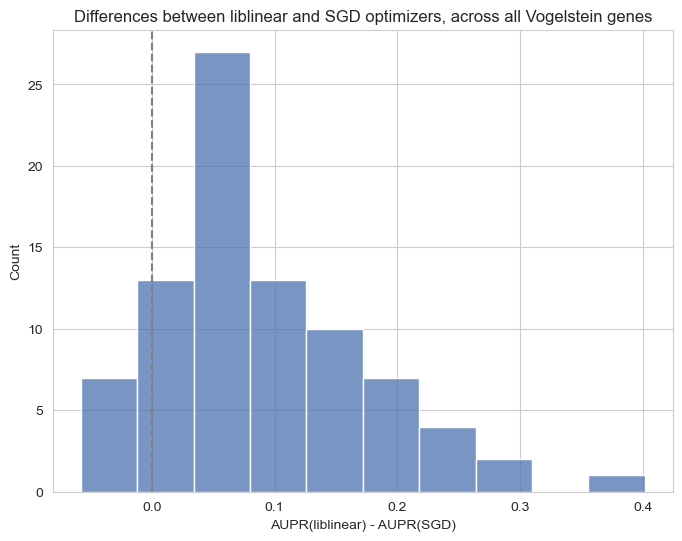

In [7]:
sns.set({'figure.figsize': (8, 6)})
sns.set_style('whitegrid')

sns.histplot(all_top_optimizer_diff_df.ll_sgd_diff)
plt.title('Differences between liblinear and SGD optimizers, across all Vogelstein genes')
plt.xlabel('AUPR(liblinear) - AUPR(SGD)')
plt.gca().axvline(0, color='grey', linestyle='--')

In [8]:
all_top_optimizer_diff_df.sort_values(by='ll_sgd_diff', ascending=False).head(10)

,gene,ll_top_lasso_param,sgd_top_lasso_param,ll_sgd_diff,best
66,FUBP1,10.00,0.10000,0.401069,liblinear
64,CDH1,0.05,0.10000,0.294805,liblinear
75,CASP8,10.00,0.05000,0.268601,liblinear
41,EGFR,0.01,0.01000,0.257807,liblinear
36,STAG2,0.05,0.00001,0.245292,liblinear
71,NFE2L2,0.05,0.01000,0.244443,liblinear
37,SMAD4,0.05,0.00001,0.228604,liblinear
2,KDM5C,5.00,0.10000,0.217613,liblinear
76,SPOP,10.00,0.00001,0.216775,liblinear
69,NF1,0.01,0.00001,0.197363,liblinear


In [9]:
all_top_optimizer_diff_df.sort_values(by='ll_sgd_diff', ascending=True).head(10)

,gene,ll_top_lasso_param,sgd_top_lasso_param,ll_sgd_diff,best
10,NPM1,50.00,0.00050,-0.057480,sgd
8,CSF1R,50.00,0.00050,-0.055601,sgd
83,HIST1H3B,50.00,0.00500,-0.026711,sgd
44,VHL,5.00,0.00001,-0.020694,sgd
19,CREBBP,0.05,0.00001,-0.016869,sgd
30,MED12,5.00,0.00001,-0.016041,sgd
82,EZH2,10.00,0.00010,-0.013695,sgd
55,ABL1,100.00,0.00001,-0.010077,sgd
14,MAP2K1,10.00,0.50000,-0.002096,sgd
38,ARID1B,0.01,0.05000,0.000033,liblinear
